# Make a list of flares potentially seen by the NRH

The goal of this notebook is to use the STIX flare list to create a subset of flares which position and time make them visible from the NRH. We will assume that the NRH is observing everyday between 9am and 4pm. We will rely on the coarse flare location for the moment but we could instead use the images created by an automated algorithm for all flares, at a later stage.  
Authors: Laura Hayes, Sophie Musset

In [188]:
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import math
import pandas as pd
from astropy import units as u
from sunpy.coordinates import frames, get_horizons_coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astrospice
from stixdcpy.net import JSONRequest as jreq
from datetime import datetime, date, time

## Query flare list from the STIX Data Center

In [3]:
flares1 = jreq.fetch_flare_list('2020-01-01T00:00:00', '2021-01-01T00:00:00', sort='time')
flares2 = jreq.fetch_flare_list('2021-01-01T00:00:00', '2022-01-01T00:00:00', sort='time')
flares3 = jreq.fetch_flare_list('2022-01-01T00:00:00', '2022-06-01T00:00:00', sort='time')
flares4 = jreq.fetch_flare_list('2022-06-01T00:00:00', '2022-09-22T00:00:00', sort='time')
flares = flares1+flares2+flares3+flares4
stix_flares=pd.DataFrame(flares)

Plot the coarse flare locations from the flare list: these are in helioprojective coordinates at various times...

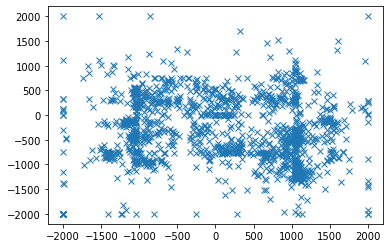

In [4]:
plt.plot(stix_flares["CFL_X_arcsec"], stix_flares["CFL_Y_arcsec"], 
         marker='x', ls='')

Sort flare list by date (if not already)

In [5]:
stix_flares.sort_values(by="start_UTC", inplace=True)
len(stix_flares)

10596

### Select only flares for which we have a CFL solution in the list

In [6]:
stix_flares2 = stix_flares[~stix_flares["CFL_X_arcsec"].isnull()]
stix_flares2.head()

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec
273,2006061015,840,2020-06-06T10:15:03.201,271.0,6,B1.1,1.088304e-07,0.0,0.0,2020-06-06T10:08:11.201,2020-06-06T10:22:11.201,399
271,2006061838,552,2020-06-06T18:38:39.200,271.0,8,A,7.108392e-08,0.0,0.0,2020-06-06T18:36:19.200,2020-06-06T18:45:31.200,367
270,2006061909,1056,2020-06-06T19:09:27.200,271.0,9,B2.7,2.733632e-07,-1960.0,-470.0,2020-06-06T19:06:03.200,2020-06-06T19:23:39.200,671
269,2006061943,664,2020-06-06T19:43:23.200,271.0,10,B1.2,1.204898e-07,0.0,0.0,2020-06-06T19:37:59.200,2020-06-06T19:49:03.200,367
268,2006062022,716,2020-06-06T20:22:43.200,271.0,11,B1.5,1.499324e-07,0.0,0.0,2020-06-06T20:14:59.200,2020-06-06T20:26:55.200,463


In [7]:
len(stix_flares2)

2122

## Coordinate transformation
### Get Solar Orbiter coordinates at the time of each flare

In [8]:
times = Time(pd.to_datetime(stix_flares2["start_UTC"]))

In [9]:
kernals = astrospice.registry.get_kernels("solar orbiter", "predict")

C:\Users\Sophie.Musset\Anaconda3\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [10]:
solo_coords = astrospice.generate_coords("SOLAR ORBITER", times)

Check coordinates

In [11]:
solo_coords[0]

<SkyCoord (ICRS): (x, y, z) in km
    (38483327.58839749, -62489490.95173176, -26115320.0328418)>

### Create coordinates for all flares
Create a SkyCoord object for each flare

In [12]:
coord1 = SkyCoord(stix_flares2["CFL_X_arcsec"]*u.arcsec,  stix_flares2["CFL_Y_arcsec"]*u.arcsec, 
                  observer=solo_coords, frame=frames.Helioprojective)

Transform these coordinates into Heliographic Stonyhurst

In [14]:
coords_hgs = coord1.transform_to(frames.HeliographicStonyhurst)

### Transform into coordinates as seen from Earth
Create a coordinate frame with Earth as an observer for all flares

In [13]:
frames_earth = frames.Helioprojective(observer="earth", obstime=times)

Transform flare coordinates into Helioprojective coordinates as seen from Earth at the times of the flares

In [15]:
coord_earth = coord1.transform_to(frames_earth)

Find the number of flares which are lost in the transformation (they are not on disk as seen from the Earth)

In [17]:
np.sum(np.isnan(coord_earth.Tx.value))

589

In [20]:
len(times)

2122

## Plot Solar Orbiter orbit for these flares

Find Solar Orbiter, Sun and Earth coordinates at the times of the flares

In [21]:
solo_coords = astrospice.generate_coords("SOLAR ORBITER", times).heliographic_stonyhurst
earth_coords = astrospice.generate_coords("earth", times).heliographic_stonyhurst
sun_coords = astrospice.generate_coords("sun", times).heliographic_stonyhurst

Create tick marks with the times of the flares

In [22]:
ticks = dates.date2num(times.datetime)

Plot the positions

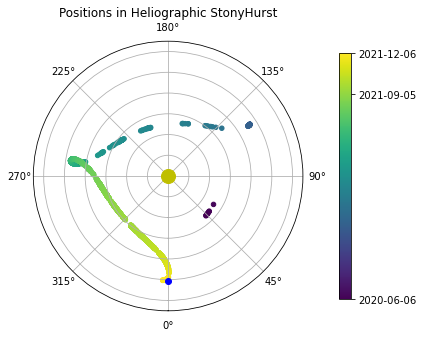

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords.lon.to(u.rad), 
           solo_coords.radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords[0].lon.to(u.rad), 
           earth_coords[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords[0].lon.to(u.rad), 
        sun_coords[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)



ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()

## Plot flare positions as seen from Earth

[Text(1, 18419.422351863424, '2020-06-06'),
 Text(1, 18875.86157378472, '2021-09-05'),
 Text(1, 18967.580137314817, '2021-12-06')]

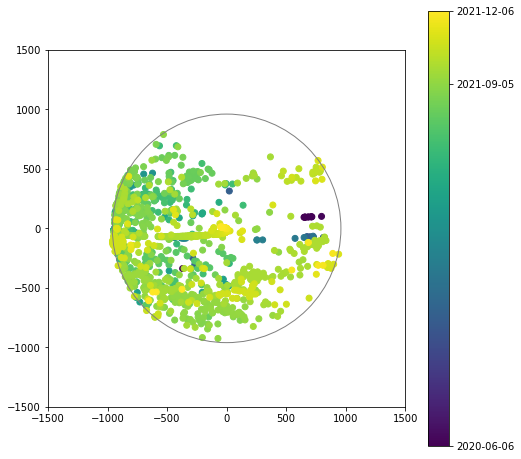

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.scatter(coord_earth.Tx, coord_earth.Ty, c=ticks)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], )
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar

## Exclude flares with CFL solution = (0,0)

Many flares seem to have (0,0) as entries for their CFL... Maybe that is a case where the CFL was not available. Let's remove them

In [78]:
stix_flares3 = stix_flares2.loc[(stix_flares2['CFL_X_arcsec'] != 0) | (stix_flares2['CFL_Y_arcsec'] != 0)]
stix_flares3

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,PeakTimeUTC
270,2006061909,1056,2020-06-06T19:09:27.200,271.0,9,B2.7,2.733632e-07,-1960.0,-470.0,2020-06-06T19:06:03.200,2020-06-06T19:23:39.200,671,19:09:27.200000
264,2006070508,400,2020-06-07T05:08:39.100,271.0,15,B1.6,1.633966e-07,-1960.0,-490.0,2020-06-07T05:06:11.100,2020-06-07T05:12:51.100,607,05:08:39.100000
263,2006072042,320,2020-06-07T20:42:03.100,271.0,16,B1.5,1.450681e-07,-2000.0,-300.0,2020-06-07T20:39:31.100,2020-06-07T20:44:51.102,543,20:42:03.100000
261,2006072140,536,2020-06-07T21:40:35.100,271.0,18,B6.4,6.433746e-07,-1620.0,-700.0,2020-06-07T21:37:55.100,2020-06-07T21:46:51.100,2687,21:40:35.100000
253,2011152307,896,2020-11-15T23:07:36.570,335.0,30,B1.0,1.028953e-07,1060.0,-340.0,2020-11-15T23:02:44.570,2020-11-15T23:17:40.571,1855,23:07:36.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2112051924,1792,2021-12-05T19:24:51.851,247.0,2896,C1.6,1.613269e-06,1050.0,-420.0,2021-12-05T19:22:43.850,2021-12-05T19:52:35.853,1983,19:24:51.851000
807,2112060634,284,2021-12-06T06:34:59.819,247.0,2900,C1.0,1.028531e-06,-330.0,-510.0,2021-12-06T06:32:47.819,2021-12-06T06:37:31.819,927,06:34:59.819000
806,2112060653,160,2021-12-06T06:53:15.821,247.0,2901,C1.3,1.307769e-06,-620.0,-600.0,2021-12-06T06:52:11.821,2021-12-06T06:54:51.821,3455,06:53:15.821000
805,2112060723,144,2021-12-06T07:23:47.824,247.0,2902,B5.4,5.386274e-07,-580.0,-530.0,2021-12-06T07:22:39.824,2021-12-06T07:25:03.824,991,07:23:47.824000


Read indexes: select the flares that are in the stix_flares3 selection

In [157]:
ind2 = stix_flares2.index.values
ind3 = stix_flares3.index.values
res = np.intersect1d(ind2,ind3,assume_unique=False, return_indices=True)

In [158]:
indexes = np.sort(res[1])

Plot again the position of Solar Orbiter but with that selection

In [159]:
ticks = dates.date2num(times[indexes].datetime)

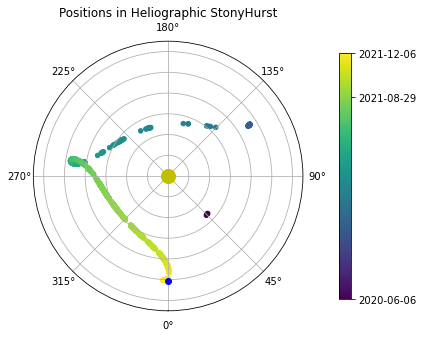

In [160]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords[indexes].lon.to(u.rad), 
           solo_coords[indexes].radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords[0].lon.to(u.rad), 
           earth_coords[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords[0].lon.to(u.rad), 
        sun_coords[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)



ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()

Plot again the flare location as seen from Earth but with that selection

[Text(1, 18419.79587037037, '2020-06-06'),
 Text(1, 18868.358619733794, '2021-08-29'),
 Text(1, 18967.324812800925, '2021-12-06')]

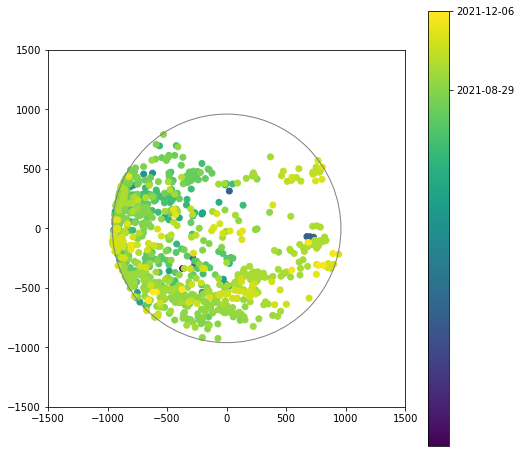

In [161]:
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.scatter(coord_earth[indexes].Tx, coord_earth[indexes].Ty, c=ticks)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], )
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar

## Select flares happening during NRH observation times

Define observation times for the NRH

In [35]:
nrh_start = time(9)
nrh_end = time(16)

Define a new variable that we will add in the dataframe

In [162]:
peak_time = pd.to_datetime(stix_flares3["peak_UTC"]).dt.time

Make a copy of the dataframe and add a new column with only the time of the peak of the flare (not the date)

In [163]:
stix_flares4 = stix_flares3
stix_flares4['PeakTimeUTC'] = peak_time

<ipython-input-163-67364d4fd0a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares4['PeakTimeUTC'] = peak_time


Check that the new dataframe has a new column

In [165]:
stix_flares4

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,PeakTimeUTC
270,2006061909,1056,2020-06-06T19:09:27.200,271.0,9,B2.7,2.733632e-07,-1960.0,-470.0,2020-06-06T19:06:03.200,2020-06-06T19:23:39.200,671,19:09:27.200000
264,2006070508,400,2020-06-07T05:08:39.100,271.0,15,B1.6,1.633966e-07,-1960.0,-490.0,2020-06-07T05:06:11.100,2020-06-07T05:12:51.100,607,05:08:39.100000
263,2006072042,320,2020-06-07T20:42:03.100,271.0,16,B1.5,1.450681e-07,-2000.0,-300.0,2020-06-07T20:39:31.100,2020-06-07T20:44:51.102,543,20:42:03.100000
261,2006072140,536,2020-06-07T21:40:35.100,271.0,18,B6.4,6.433746e-07,-1620.0,-700.0,2020-06-07T21:37:55.100,2020-06-07T21:46:51.100,2687,21:40:35.100000
253,2011152307,896,2020-11-15T23:07:36.570,335.0,30,B1.0,1.028953e-07,1060.0,-340.0,2020-11-15T23:02:44.570,2020-11-15T23:17:40.571,1855,23:07:36.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2112051924,1792,2021-12-05T19:24:51.851,247.0,2896,C1.6,1.613269e-06,1050.0,-420.0,2021-12-05T19:22:43.850,2021-12-05T19:52:35.853,1983,19:24:51.851000
807,2112060634,284,2021-12-06T06:34:59.819,247.0,2900,C1.0,1.028531e-06,-330.0,-510.0,2021-12-06T06:32:47.819,2021-12-06T06:37:31.819,927,06:34:59.819000
806,2112060653,160,2021-12-06T06:53:15.821,247.0,2901,C1.3,1.307769e-06,-620.0,-600.0,2021-12-06T06:52:11.821,2021-12-06T06:54:51.821,3455,06:53:15.821000
805,2112060723,144,2021-12-06T07:23:47.824,247.0,2902,B5.4,5.386274e-07,-580.0,-530.0,2021-12-06T07:22:39.824,2021-12-06T07:25:03.824,991,07:23:47.824000


Select flares with their peak time within the observation time for the NRH

In [166]:
stix_flares_nrh = stix_flares4.loc[(stix_flares4['PeakTimeUTC'] >= nrh_start) & (stix_flares4['PeakTimeUTC'] <= nrh_end)]

Check that data frame

In [167]:
stix_flares_nrh

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,PeakTimeUTC
235,2011160909,792,2020-11-16T09:09:12.527,335.0,48,B1.3,1.270498e-07,1050.0,-320.0,2020-11-16T09:03:20.526,2020-11-16T09:16:32.528,13823,09:09:12.527000
233,2011161001,4852,2020-11-16T10:01:52.532,335.0,50,B2.1,2.067574e-07,1040.0,-390.0,2020-11-16T09:45:04.530,2020-11-16T11:05:56.538,77823,10:01:52.532000
229,2011161249,224,2020-11-16T12:49:32.548,335.0,54,A,9.782588e-08,1060.0,-270.0,2020-11-16T12:48:24.548,2020-11-16T12:52:08.548,2943,12:49:32.548000
224,2011161429,440,2020-11-16T14:29:32.557,335.0,59,A,9.172547e-08,1060.0,-330.0,2020-11-16T14:27:04.557,2020-11-16T14:34:24.557,3711,14:29:32.557000
170,2011170933,284,2020-11-17T09:33:12.464,335.0,113,A,6.136133e-08,1060.0,-280.0,2020-11-17T09:31:32.464,2020-11-17T09:36:16.465,2431,09:33:12.464000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,2111280922,580,2021-11-28T09:22:31.671,247.0,2838,B7.0,6.957550e-07,770.0,-310.0,2021-11-28T09:19:39.671,2021-11-28T09:29:19.672,607,09:22:31.671000
868,2111281011,724,2021-11-28T10:11:19.676,271.0,2839,B6.3,6.293923e-07,550.0,-350.0,2021-11-28T10:07:55.676,2021-11-28T10:19:59.677,495,10:11:19.676000
867,2111281336,748,2021-11-28T13:36:11.697,247.0,2840,B6.3,6.331902e-07,1000.0,100.0,2021-11-28T13:30:59.696,2021-11-28T13:43:27.697,607,13:36:11.697000
854,2111291308,536,2021-11-29T13:08:39.639,247.0,2853,B4.6,4.615033e-07,1060.0,0.0,2021-11-29T13:06:35.639,2021-11-29T13:15:31.640,607,13:08:39.639000


Read indexes for the flares selected

In [168]:
ind2 = stix_flares2.index.values
ind3 = stix_flares_nrh.index.values
res = np.intersect1d(ind2,ind3,assume_unique=False, return_indices=True)
indexes = np.sort(res[1])

Plot Solar Orbiter positions for this selection

In [247]:
ticks = dates.date2num(times[indexes].datetime)

414

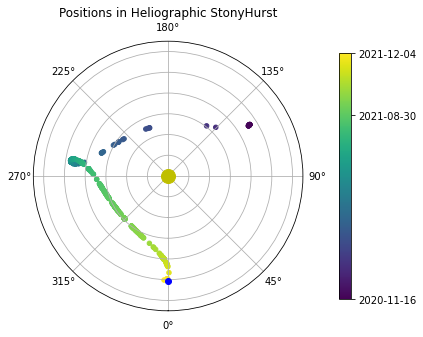

In [238]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords[indexes].lon.to(u.rad), 
           solo_coords[indexes].radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords[0].lon.to(u.rad), 
           earth_coords[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords[0].lon.to(u.rad), 
        sun_coords[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)



ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()

Plot flare positions seen from Earth

[Text(1, 18582.37732090278, '2020-11-16'),
 Text(1, 18869.411951377315, '2021-08-30'),
 Text(1, 18965.42949011574, '2021-12-04')]

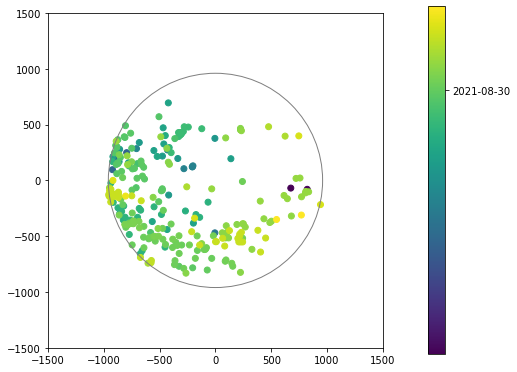

In [246]:
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.scatter(coord_earth[indexes].Tx, coord_earth[indexes].Ty, c=ticks)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.8)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                        dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                        dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar

Number of flares lost with the transformation

In [174]:
np.sum(np.isnan(coord_earth[indexes].Tx.value))

150

Add the location seen from Earth to the dataframe

In [179]:
X_from_earth = coord_earth[indexes].Tx.value
Y_from_earth = coord_earth[indexes].Ty.value

In [180]:
stix_flares_nrh['X_from_Earth']=X_from_earth

<ipython-input-180-bb9780cc3b36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_nrh['X_from_Earth']=X_from_earth


In [181]:
stix_flares_nrh['Y_from_Earth']=Y_from_earth

<ipython-input-181-b686c9907f07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_nrh['Y_from_Earth']=Y_from_earth


In [182]:
stix_flares_nrh

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,PeakTimeUTC,X_from_Earth,Y_from_Earth
235,2011160909,792,2020-11-16T09:09:12.527,335.0,48,B1.3,1.270498e-07,1050.0,-320.0,2020-11-16T09:03:20.526,2020-11-16T09:16:32.528,13823,09:09:12.527000,NaN,NaN
233,2011161001,4852,2020-11-16T10:01:52.532,335.0,50,B2.1,2.067574e-07,1040.0,-390.0,2020-11-16T09:45:04.530,2020-11-16T11:05:56.538,77823,10:01:52.532000,NaN,NaN
229,2011161249,224,2020-11-16T12:49:32.548,335.0,54,A,9.782588e-08,1060.0,-270.0,2020-11-16T12:48:24.548,2020-11-16T12:52:08.548,2943,12:49:32.548000,NaN,NaN
224,2011161429,440,2020-11-16T14:29:32.557,335.0,59,A,9.172547e-08,1060.0,-330.0,2020-11-16T14:27:04.557,2020-11-16T14:34:24.557,3711,14:29:32.557000,NaN,NaN
170,2011170933,284,2020-11-17T09:33:12.464,335.0,113,A,6.136133e-08,1060.0,-280.0,2020-11-17T09:31:32.464,2020-11-17T09:36:16.465,2431,09:33:12.464000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,2111280922,580,2021-11-28T09:22:31.671,247.0,2838,B7.0,6.957550e-07,770.0,-310.0,2021-11-28T09:19:39.671,2021-11-28T09:29:19.672,607,09:22:31.671000,769.640122,-310.464872
868,2111281011,724,2021-11-28T10:11:19.676,271.0,2839,B6.3,6.293923e-07,550.0,-350.0,2021-11-28T10:07:55.676,2021-11-28T10:19:59.677,495,10:11:19.676000,547.344095,-350.240136
867,2111281336,748,2021-11-28T13:36:11.697,247.0,2840,B6.3,6.331902e-07,1000.0,100.0,2021-11-28T13:30:59.696,2021-11-28T13:43:27.697,607,13:36:11.697000,NaN,NaN
854,2111291308,536,2021-11-29T13:08:39.639,247.0,2853,B4.6,4.615033e-07,1060.0,0.0,2021-11-29T13:06:35.639,2021-11-29T13:15:31.640,607,13:08:39.639000,NaN,NaN


Select the flares that are on disk as seen from Earth

In [184]:
stix_flares_nrh_ondisk = stix_flares_nrh[~stix_flares_nrh["X_from_Earth"].isnull()]
stix_flares_nrh_ondisk

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,PeakTimeUTC,X_from_Earth,Y_from_Earth
99,2011181151,176,2020-11-18T11:51:36.612,335.0,184,A,4.969928e-08,240.0,0.0,2020-11-18T11:50:44.612,2020-11-18T11:53:40.613,1343,11:51:36.612000,674.831040,-68.849859
21,2011211038,116,2020-11-21T10:38:16.911,303.0,261,B2.2,2.198911e-07,-10.0,0.0,2020-11-21T10:37:20.911,2020-11-21T10:39:16.911,1215,10:38:16.911000,822.202674,-79.903067
3183,2103181453,136,2021-03-18T14:53:07.347,271.0,472,A,3.462075e-08,80.0,350.0,2021-03-18T14:52:07.347,2021-03-18T14:54:23.347,5375,14:53:07.347000,-885.183992,221.984004
3181,2103191405,732,2021-03-19T14:05:31.189,271.0,474,A,3.917223e-08,-220.0,420.0,2021-03-19T14:02:43.189,2021-03-19T14:14:55.194,1215,14:05:31.189000,-796.103980,248.733163
3172,2103200906,280,2021-03-20T09:06:39.105,271.0,483,A,4.056589e-08,70.0,310.0,2021-03-20T09:05:07.105,2021-03-20T09:09:47.105,1087,09:06:39.105000,-895.340474,200.079101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,2111051529,280,2021-11-05T15:29:03.121,247.0,2746,C1.7,1.685939e-06,870.0,480.0,2021-11-05T15:27:59.121,2021-11-05T15:32:39.121,9727,15:29:03.121000,746.778406,398.918183
922,2111080923,888,2021-11-08T09:23:11.624,247.0,2785,C1.1,1.077254e-06,-1040.0,10.0,2021-11-08T09:18:51.623,2021-11-08T09:33:39.625,2431,09:23:11.624000,-918.688475,-0.183483
887,2111171505,124,2021-11-17T15:05:04.178,247.0,2820,B2.5,2.530227e-07,-860.0,-140.0,2021-11-17T15:04:00.178,2021-11-17T15:06:04.178,1087,15:05:04.178000,-805.945435,-140.317822
869,2111280922,580,2021-11-28T09:22:31.671,247.0,2838,B7.0,6.957550e-07,770.0,-310.0,2021-11-28T09:19:39.671,2021-11-28T09:29:19.672,607,09:22:31.671000,769.640122,-310.464872


## What kind of flares did we get?

In [248]:
goes = np.array(stix_flares_nrh_ondisk['GOES_flux'])

In [221]:
goes_class = np.log10(goes)

<ipython-input-221-91c7bc2d5ad2>:1: RuntimeWarning: divide by zero encountered in log10
  goes_class = np.log10(goes)


In [228]:
goes_class2 = goes_class[np.isfinite(goes_class)]

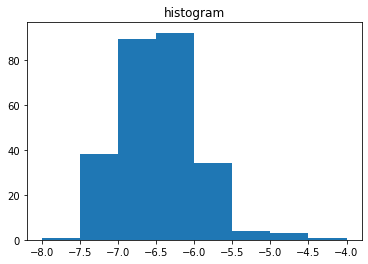

In [232]:
plt.hist(goes_class2, bins = [-8,-7.5,-7,-6.5,-6,-5.5,-5,-4.5,-4])
plt.title("histogram")
plt.show()